# Steganan

## Steganography in floating point data with NaN payloads

Kelsey Jordahl

SciPy 2025 Lightning Talk

## NaN values in IEEE-754 floating point numbers

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/IEEE_754_Double_Floating_Point_Format.svg/1280px-IEEE_754_Double_Floating_Point_Format.svg.png" width="500" alt="bits">

sign = either 0 or 1.\
exponent = all bits set to 1.\
fraction (significand) = anything _except_ all bits set to 0 (to distinguish from Inf)

NaN values can be "quiet" or "signaling" depending on whether the most signficant bit is set.\
For a "quiet" float64 NaN, there are 51 unused bits available as "payload"!

## IEEE-754-2019

recommends language-dependent implementation of getPayload() and setPayload() functions on NaNs. These are already in C23 standard and glibc, e.g.
```
int setpayload (double *x, double payload)
int setpayloadl (long double *x, long double payload)
```
What about NumPy?

## NaN payload bit manipulation with NumPy

In [1]:
import numpy as np

nan_mask = np.float32(np.nan).view(np.int32)
print(nan_mask)
print(hex(nan_mask))
print(bin(nan_mask))

2143289344
0x7fc00000
0b1111111110000000000000000000000


In [2]:
arr = np.random.randint(10000, size=(4, 4), dtype=np.int32)
print(arr)

[[8572 6519 9174  124]
 [3533 6334 8547 6582]
 [1418 8590 4364 7556]
 [9362 3047 5750 5765]]


In [3]:
encoded = arr | nan_mask
print(encoded)

[[2143297916 2143295863 2143298518 2143289468]
 [2143292877 2143295678 2143297891 2143295926]
 [2143290762 2143297934 2143293708 2143296900]
 [2143298706 2143292391 2143295094 2143295109]]


In [4]:
new_array = encoded.view(np.float32)

In [5]:
np.isnan(new_array)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

# Introducing the `steganan` library
## Hiding an integer array in an array of NaN values

In [6]:
test_arr = np.random.randint(1000, size=(4, 4), dtype=np.uint32)
print(test_arr)

[[841 991 511  89]
 [ 60 251 466 909]
 [402 994 177 928]
 [559 503 151  53]]


In [7]:
from steganan import steganan

secret = steganan.encode_array(test_arr, dtype=np.float32)
print("encoded:\n", secret)

encoded:
 [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


In [8]:
print("decoded:\n", steganan.decode_array(secret))

decoded:
 [[841 991 511  89]
 [ 60 251 466 909]
 [402 994 177 928]
 [559 503 151  53]]


## Storing image data in an array of NaN values

In [9]:
import matplotlib.pyplot as plt
from skimage.data import astronaut

img = astronaut()
print(img.shape)
print(img.dtype)

(512, 512, 3)
uint8


In [10]:
a = steganan.encode_array(img, stack=True, dtype=np.float64)
print(a)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


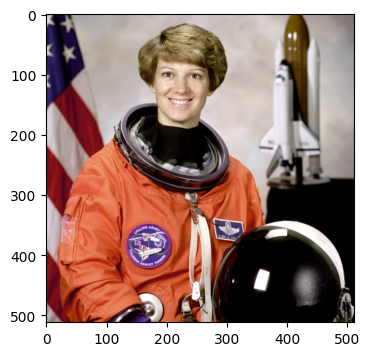

In [11]:
decoded = steganan.decode_array(a, stack=True, depth=3)
plt.figure(figsize=(4, 4))
plt.imshow(decoded)

## Hiding data in an existing floating point array

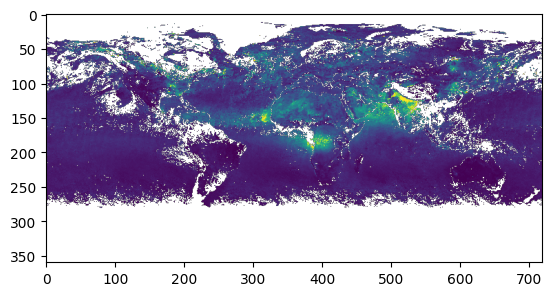

In [12]:
import rasterio as rio

src = rio.open("../data/modis_aod_06_2025.tif")
a = src.read(1)
steganan.write_str_to_nans(a, "I have a secret!")
plt.imshow(a)

In [13]:
message = steganan.retrieve_string_from_payloads(a)
print(message)

I have a secret!


Data from [NASA Earth Observations](https://neo.gsfc.nasa.gov/view.php?datasetId=MODAL2_M_AER_OD&date=2025-06-01)

# Thanks!

## Prior art
[the secret life of NaN](https://anniecherkaev.com/the-secret-life-of-nan) by Annie Cherkaev \
[NaN boxing or how to make the world dynamic](https://piotrduperas.com/posts/nan-boxing) by Piotr Duperas

## Contact
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Octicons-mark-github.svg/64px-Octicons-mark-github.svg.png?20180806170715=&download=" width="20" alt="GitHub logo"> [`@kjordahl/steganan`](https://github.com/kjordahl/steganan) \
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Mastodon_logotype_%28simple%29_new_hue.svg/65px-Mastodon_logotype_%28simple%29_new_hue.svg.png" width="20" alt="Mastodon logo"> [`@kajord@hachyderm.io`](https://hachyderm.io/@kajord)